In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import tensorflow_addons as tfa

In [3]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [4]:
training_data = load_training_data(root_dir="/Users/spx8sk/work/projects/wispy/dev-stack/training_data")

In [5]:
validation_data = load_training_data(root_dir="/Users/spx8sk/work/projects/wispy/dev-stack/validation_data")

In [6]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [7]:
# lets just take the phenomD data for now

In [8]:
training_data['unique_approximants']

array(['IMRPhenomD', 'NR', 'SEOBNRv4_opt'], dtype='<U12')

In [134]:
# mask = training_data['mask']['IMRPhenomD']
# # mask = training_data['mask']['NR']
# # mask = training_data['mask']['SEOBNRv4_opt']
# y = training_data['amplitude'][mask]
# # y = training_data['phase'][mask]
# x = training_data['mass_ratios'][mask]
# yval = validation_data['amplitude'][mask]
# xval = validation_data['mass_ratios'][mask]
# times = training_data['times']

In [129]:
# y = training_data['amplitude']
y = training_data['phase']
x = training_data['mass_ratios']
# yval = validation_data['amplitude']
yval = validation_data['phase']
xval = validation_data['mass_ratios']
times = training_data['times']

In [130]:
print(y.shape)

(205, 1150)


In [131]:
print(yval.shape)

(360, 1150)


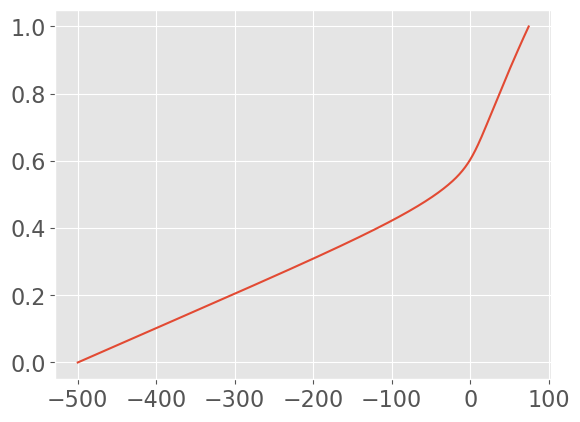

In [132]:
plt.figure()
plt.plot(times, y[0])
plt.show()

In [133]:
def build_encoder(input_shape, latent_dim, units, acts):
    # build the encoder
    timeseries_input = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(timeseries_input)
        else:
            x = layers.Dense(unit, activation=act)(x)
    latent_output = layers.Dense(latent_dim)(x)
    encoder_model = keras.Model(timeseries_input, latent_output)
#     print("=" * 20)
#     print("encoder summary")
#     print("=" * 20)
#     encoder_model.summary()

    return encoder_model


def build_decoder(input_shape, latent_dim, units, acts):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(latent_input)
        else:
            x = layers.Dense(unit, activation=act)(x)
    timeseries_output = layers.Dense(input_shape, activation="linear")(x)
    decoder_model = keras.Model(latent_input, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model


def build_and_compile_autoencoder(
    input_shape, encoder_model, decoder_model, opt, loss, metrics
):
    # build the AE
    timeseries_input = keras.Input(shape=(input_shape,))
    latent = encoder_model(timeseries_input)
    timeseries_output = decoder_model(latent)
    ae_model = keras.Model(timeseries_input, timeseries_output)
#     print("=" * 20)
#     print("autoencoder summary")
#     print("=" * 20)
#     ae_model.summary()

    ae_model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return ae_model




In [151]:
def make_model(y, yval, latent_dim, epochs=1000, batch_size=100, lr=1e-3):
    input_shape = y.shape[1]
    encoder_units = [128, 16]
    encoder_acts = ['relu', 'relu']

    decoder_units = [16, 128]
    decoder_acts = ['relu', 'relu']

#     decoder_units = [16, 128, 128, 128]
#     decoder_acts = ['relu', 'relu', 'relu', 'relu']

    loss = 'mae'
    metrics = ['mse']

    opt = tf.keras.optimizers.Adam(lr)

    encoder_model = build_encoder(input_shape, latent_dim, encoder_units, encoder_acts)
    decoder_model = build_decoder(input_shape, latent_dim, decoder_units, decoder_acts)
    model = build_and_compile_autoencoder(
        input_shape, encoder_model, decoder_model, opt, loss, metrics
    )

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    history = model.fit(y, y, epochs=epochs, callbacks=callbacks, verbose=0, validation_data=(yval, yval), batch_size=batch_size)
    
    return history, model, encoder_model, decoder_model

In [212]:
%%time
history_1, model_1, encoder_model_1, decoder_model_1 = make_model(y, yval, latent_dim=1, epochs=5000, batch_size=100, lr=1e-2)


CPU times: user 6min 50s, sys: 1min 35s, total: 8min 25s
Wall time: 5min 30s


In [186]:
history_1.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

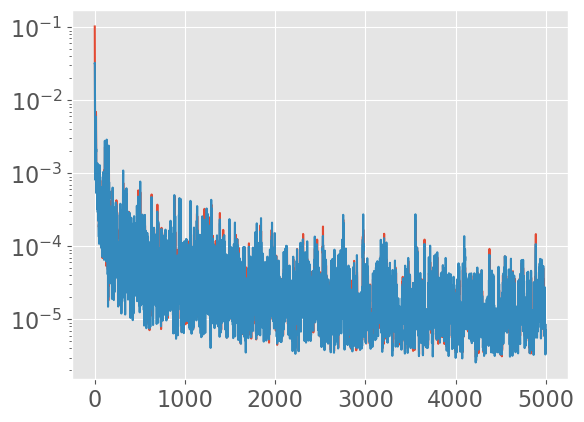

In [213]:
plt.figure()
plt.plot(history_1.history['mse'])
plt.plot(history_1.history['val_mse'])
plt.yscale('log')
plt.show()
plt.close()

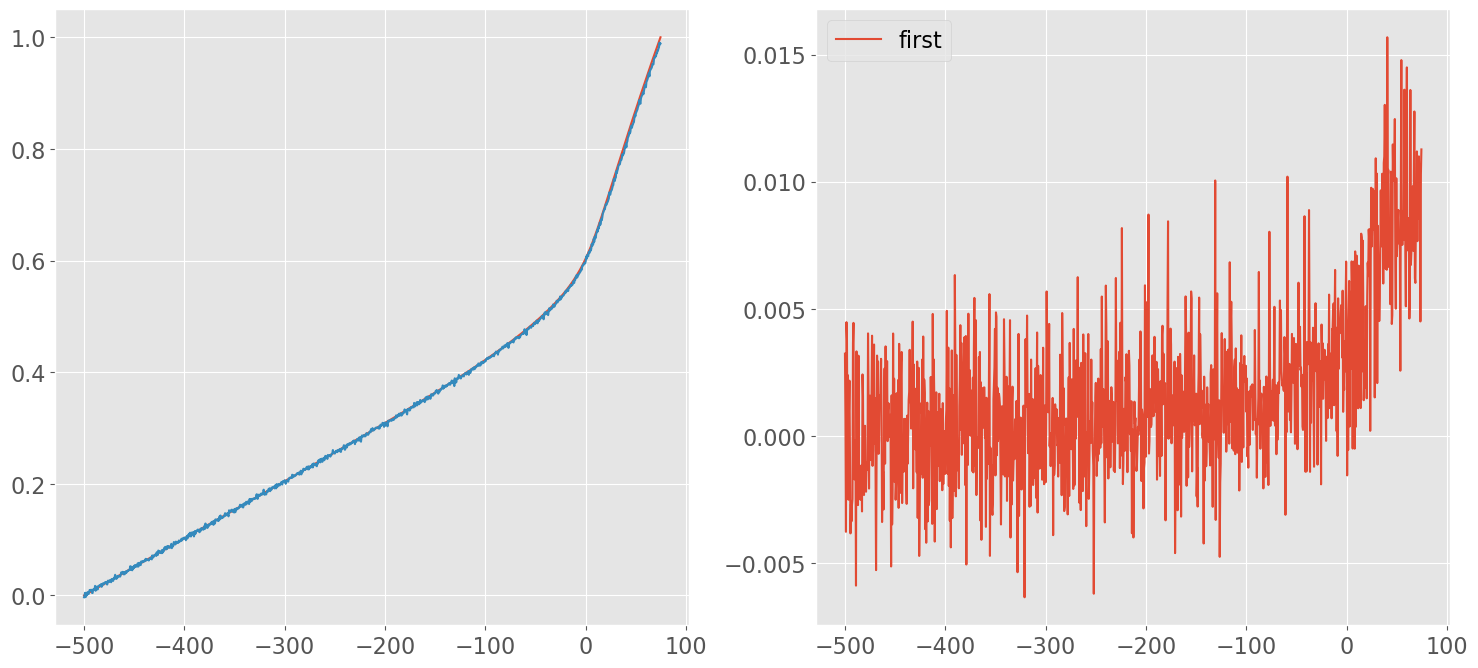

In [214]:
# two outputs
index=0
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[index])
plt.plot(times, model_1.predict(y)[index])

plt.subplot(1, 2, 2)
plt.plot(times, y[index]-model_1.predict(y)[index], label='first')
plt.legend()
plt.show()
plt.close()

In [215]:
latent_model_1 = encoder_model_1(y)

In [216]:
latent_model_1.shape

TensorShape([205, 1])

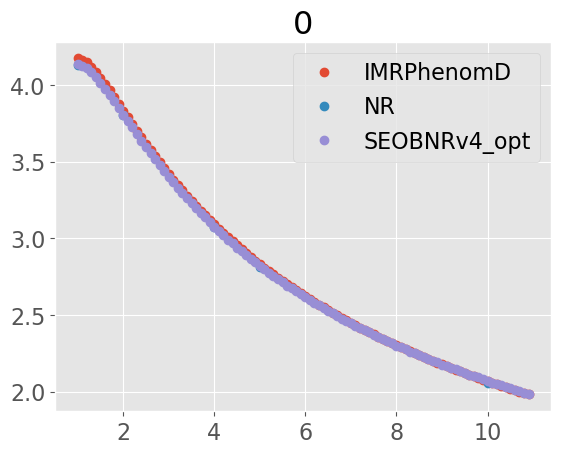

In [217]:
for i in range(latent_model_1.shape[1]):
    plt.figure()
    for name in training_data['unique_approximants']:
        mask = training_data['mask'][name]
        plt.plot(training_data['mass_ratios'][mask], latent_model_1.numpy()[:, i][mask], 'o', label=name)
    plt.legend()
    plt.title(i)
    plt.show()
    plt.close()

In [192]:
yRes = y-model_1.predict(y)
yRes_val = yval-model_1.predict(yval)

In [200]:
%%time
history_2, model_2, encoder_model_2, decoder_model_2 = make_model(yRes, yRes_val, latent_dim=2, epochs=5000, batch_size=100, lr=1e-3)


CPU times: user 6min 41s, sys: 1min 37s, total: 8min 19s
Wall time: 5min 17s


In [201]:
history_2.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

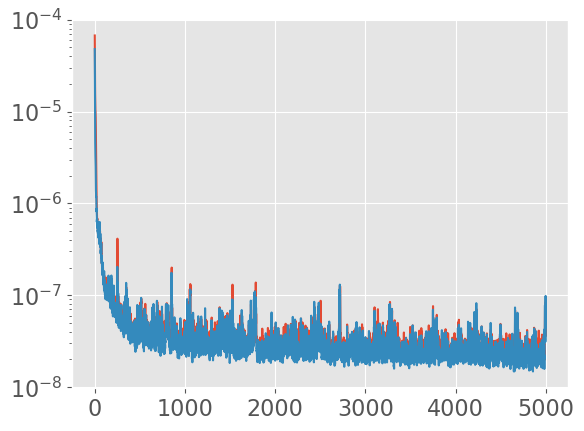

In [202]:
plt.figure()
plt.plot(history_2.history['mse'])
plt.plot(history_2.history['val_mse'])
plt.yscale('log')
plt.show()
plt.close()

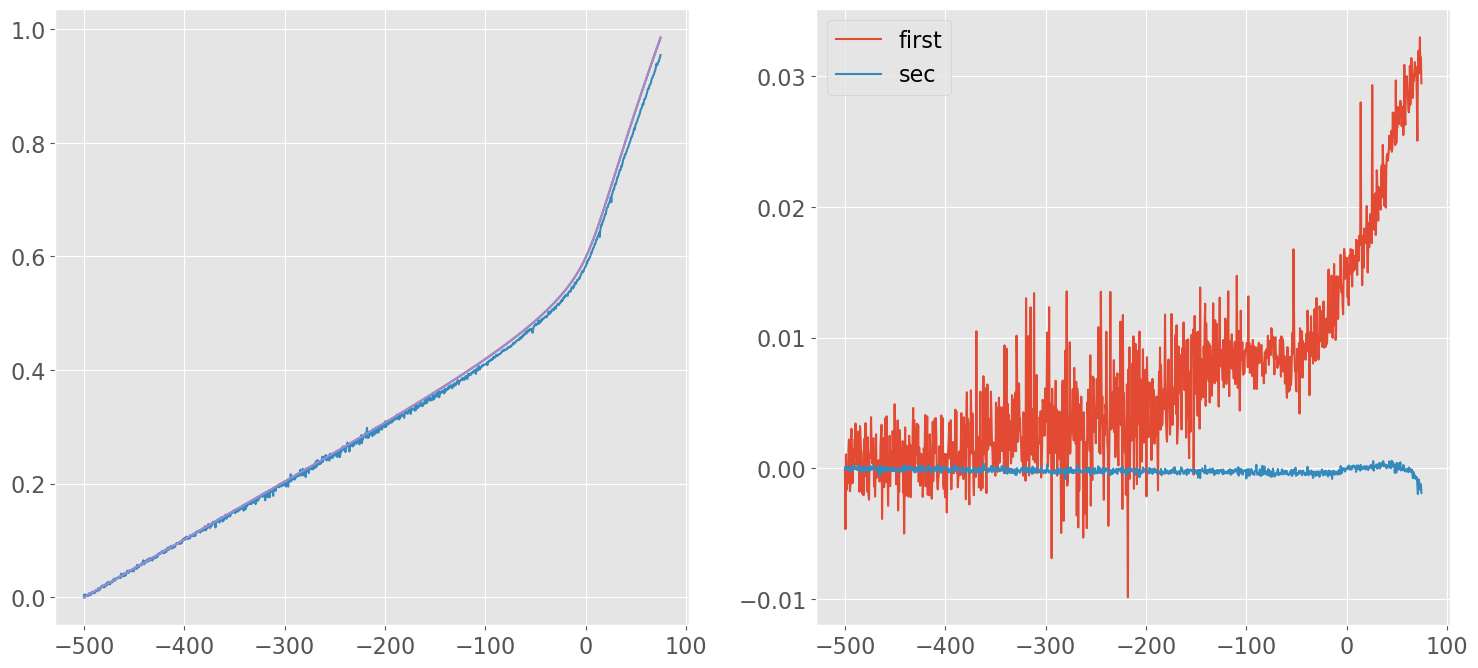

In [211]:
# two outputs
index=4
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(times, y[index])
plt.plot(times, model_1.predict(y)[index])

yhat_2 = model_1.predict(y)[index] + model_2.predict(yRes)[index]

plt.plot(times, yhat_2)

plt.subplot(1, 2, 2)
plt.plot(times, y[index]-model_1.predict(y)[index], label='first')
plt.plot(times, y[index]-yhat_2, label='sec')
plt.legend()
plt.show()
plt.close()

In [206]:
latent_model_2 = encoder_model_2(yRes)

In [207]:
latent_model_2.shape

TensorShape([205, 2])

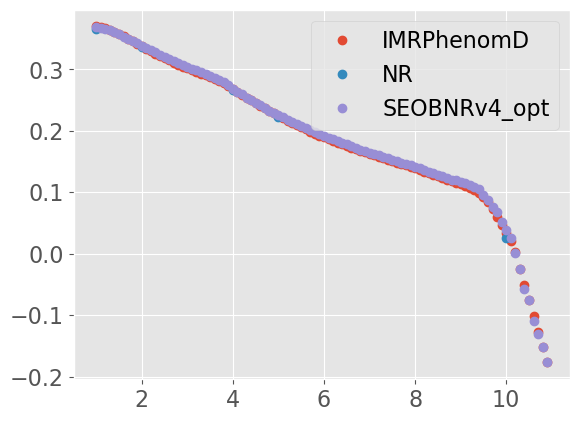

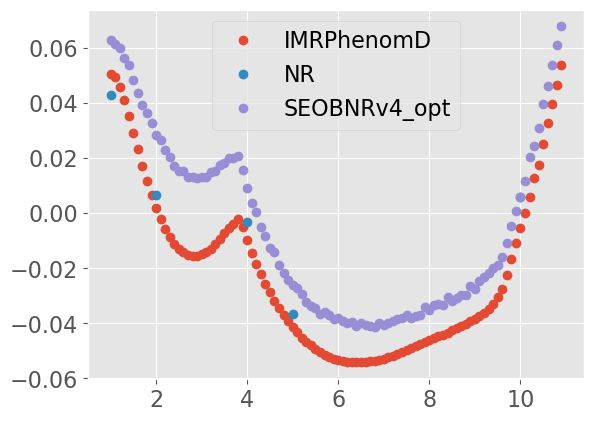

In [208]:
for i in range(latent_model_2.shape[1]):
    plt.figure()
    for name in training_data['unique_approximants']:
        mask = training_data['mask'][name]
        plt.plot(training_data['mass_ratios'][mask], latent_model_2.numpy()[:, i][mask], 'o', label=name)
    plt.legend()
    plt.show()
    plt.close()